In [118]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests


#from selenium.webdriver.common.keys import Keys

username = "espn password"
password = "account password"

driver = webdriver.Chrome("where chromedriver is placed")
driver.get("https://fantasy.espn.com/football/team?leagueId="+ league_id + "&teamId=" + your_team_id + "&seasonId="+ seasonYear + "&scoringPeriodId=1&statSplit=singleScoringPeriodtime.sleep(10)")
time.sleep(7)

iframe = driver.find_elements_by_tag_name('iframe')[2]

driver.switch_to.frame(iframe)

driver.find_element_by_xpath('//*[@id="did-ui-view"]/div/section/section/form/section/div[1]/div/label/span[2]/input').send_keys(username)
driver.find_element_by_xpath('//*[@id="did-ui-view"]/div/section/section/form/section/div[2]/div/label/span[2]/input').send_keys(password)
driver.find_element_by_xpath('//*[@id="did-ui-view"]/div/section/section/form/section/div[3]/button').click()
time.sleep(7)

driver.get("https://fantasy.espn.com/football/team?leagueId=1822630&teamId=8&seasonId=2019&scoringPeriodId=1&statSplit=singleScoringPeriodtime.sleep(10)")

time.sleep(7)

check = driver.find_elements_by_class_name('Table2__tr Table2__tr--lg Table2__odd')

tables = driver.find_elements_by_xpath('//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr[1]')


time.sleep(5)


url_first = "https://fantasy.espn.com/football/team?leagueId="+ league_id + "&teamId=" + your_team_id + "&seasonId="+ seasonYear + "&scoringPeriodId="
first_week = 1
url_second = "&statSplit=singleScoringPeriodtime.sleep(10)"


num_starters = 9 
num_bench = 7 
PRO_POINTS_EVERY_WEEK = []
poss_points = []
realized_points = [] 
#doing it for every week of the fantasy season
for h in range(13):
    driver.get(url_first+str(first_week+h)+url_second)
    time.sleep(10)
    
    
    weekly = pd.DataFrame()
    player = []
    position = []
    points = []
    for i in range(num_starters):
        first_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+1)+']/td[2]/div/div/div[2]/div/div[2]/span[2]'
        second_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+1)+']/td[2]/div/div/div[2]/div/div[1]/span[1]/a'
        third_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+1)+']/td[7]/div/span'
        position.append(driver.find_element_by_xpath(first_xpath).text)
        player.append(driver.find_element_by_xpath(second_xpath).text)
        points.append(driver.find_element_by_xpath(third_xpath).text)


    for i in range(num_bench):
        first_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+2+num_starters)+']/td[2]/div/div/div[2]/div/div[2]/span[2]'
        second_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+2+num_starters)+']/td[2]/div/div/div[2]/div/div[1]/span[1]/a'
        third_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+2+num_starters)+']/td[7]/div/span'
        position.append(driver.find_element_by_xpath(first_xpath).text)
        player.append(driver.find_element_by_xpath(second_xpath).text)
        points.append(driver.find_element_by_xpath(third_xpath).text)

    weekly = pd.DataFrame(np.transpose(np.array([position, player, points])), columns=['position', 'player', 'points'])

    weekly = weekly[weekly.points != '--']
    weekly['points'] = pd.to_numeric(weekly.iloc[:,2])

    #find weekly highest possible points
    total_score = 0
    total_score = total_score + max(weekly[weekly['position'] == 'QB'].iloc[:,2])
    total_score = total_score + max(weekly[weekly['position'] == 'TE'].iloc[:,2])
    total_score = total_score + max(weekly[weekly['position'] == 'D/ST'].iloc[:,2])
    total_score = total_score + weekly[weekly['position'] == 'RB'].nlargest(2,'points').iloc[0,2]
    total_score = total_score + weekly[weekly['position'] == 'RB'].nlargest(2,'points').iloc[1,2]
    total_score = total_score + weekly[weekly['position'] == 'WR'].nlargest(2,'points').iloc[0,2]
    total_score = total_score + weekly[weekly['position'] == 'WR'].nlargest(2,'points').iloc[1,2]

    #have to work on flex now
    #remove already used players otherwise useable
    flexing = weekly[weekly.position != 'QB']
    flexing = flexing[flexing.position != 'D/ST']

    temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'WR'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
    flexing = flexing[flexing.player != temp]

    temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'WR'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
    flexing = flexing[flexing.player != temp]

    temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'RB'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
    flexing = flexing[flexing.player != temp]

    temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'RB'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
    flexing = flexing[flexing.player != temp]

    temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'TE'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
    flexing = flexing[flexing.player != temp]

    total_score = total_score + flexing.nlargest(2,'points').iloc[0,2]
    total_score = total_score + flexing.nlargest(2,'points').iloc[1,2]
    #have to work on flex now

    total_score = round(total_score *100)
    total_score = total_score/100

    print(total_score)
    poss_points.append(total_score)
    
    
    rp = pd.to_numeric(driver.find_element_by_xpath('//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr[10]/td[6]/div').text)
    realized_points.append(rp)
    print(rp)
    print("Week", (h+1))
    
    
    
    
    
    
    ########### CALCULATING THE PRO CONSENCOUS SCORE ########################
    if (h+1) < 10:
        csv_completer = '0'+str(h+1)
    else:
        csv_completer = str(h+1)
    
    #get defense dataframe
    data = pd.read_csv("FantasyPros-W"+csv_completer+"-D.csv")
    data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']

    tempy = weekly
    tempy = tempy[tempy.position == 'D/ST']
    pros_points = 0
    rank = 150

    for team in tempy.player:
        #print(team)
        #print(tempy)
        inner_temp = tempy.iloc[0,1].split(' ')
        for i in range(len(data.player)):
            if inner_temp[0].lower() in re.sub(r'[^\w\s]','',data.iloc[i,1].lower()):
                if data.iloc[i,0] < rank:
                    answer = team
    print(answer)
    pros_points = weekly.loc[weekly['player'] == answer].iloc[0,2]

    weekly

    #get QB dataframe
    data = pd.read_csv("FantasyPros-W"+csv_completer+"-QB.csv")
    data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']

    tempy = weekly
    tempy = tempy[tempy.position == 'QB']

    rank = 150

    for player_ in tempy.player:
        #print(team)
        #print(tempy)
        inner_temp = tempy.iloc[0,1]
        for i in range(len(data.player)):
            if inner_temp[0].lower() in re.sub(r'[^\w\s]','',data.iloc[i,1].lower()):
                re.sub(r'[^\w\s]','',s)
                if data.iloc[i,0] < rank:
                    rank = data.iloc[i,0]
                    answer = player_
    print(answer)
    pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

    print('POINTS WITH DESEAN AND DEFENSE', pros_points)

    #get Flex dataframe
    data = pd.read_csv("FantasyPros-W"+csv_completer+"-Flex.csv")
    data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']

    weekly2 = weekly
    tempy = weekly2[weekly2.position == 'RB']

    rank = 200

    temp_data = data.loc[data['Position'] == 'RB']

    #need to start 2 rbs
    for j in range(2):
        #print(tempy)
        rank = 150
        for player_ in tempy.player:
            #print(player_)
            #print(type(player_))
            #inner_temp = tempy.iloc[0,1]
            for i in range(len(temp_data.player)):
                if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):
                    re.sub(r'[^\w\s]','',s)
                    #print('This was true')
                    #print(temp_data.iloc[i,1].lower())
                    #print(player_.lower())


                    if temp_data.iloc[i,0] < rank:
                        rank = temp_data.iloc[i,0]
                        #print(temp_data.iloc[i,0])
                        answer = player_


        print(answer)               
        pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

        tempy = tempy[tempy.player != answer]

        weekly2 = weekly2[weekly2.player != answer]


    #work on WRs
    tempy = weekly2[weekly2.position == 'WR']

    rank = 150

    temp_data = data.loc[data['Position'] == 'WR']

    #need to start 2 rbs
    for j in range(2):
        #print(tempy)
        rank = 200
        for player_ in tempy.player:
            #print(player_)
            #print(type(player_))
            #inner_temp = tempy.iloc[0,1]
            for i in range(len(temp_data.player)):
                if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):
                    re.sub(r'[^\w\s]','',s)
                    #print('This was tr
                    if temp_data.iloc[i,0] < rank:
                        rank = temp_data.iloc[i,0]
                        #print(temp_data.iloc[i,0])
                        answer = player_


        print(answer)             
        pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

        tempy = tempy[tempy.player != answer]

        weekly2 = weekly2[weekly2.player != answer]



    #get the TE
    tempy = weekly2[weekly2.position == 'TE']
    rank = 150
    temp_data = data.loc[data['Position'] == 'TE']

    #need to start 2 rbs
    rank = 200
    for player_ in tempy.player:
        #print(player_)
        #print(type(player_))
        #inner_temp = tempy.iloc[0,1]
        for i in range(len(temp_data.player)):
            if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):
                re.sub(r'[^\w\s]','',s)
                #print('This was true')
                #print(temp_data.iloc[i,1].lower())
                #print(player_.lower())


                if temp_data.iloc[i,0] < rank:
                    rank = temp_data.iloc[i,0]
                    #print(temp_data.iloc[i,0])
                    answer = player_


    print(answer)
    pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

    tempy = tempy[tempy.player != answer]

    weekly2 = weekly2[weekly2.player != answer]



    #get the TE

    tempy = weekly2[weekly2.position != 'QB']
    tempy = tempy[tempy.position != 'D/ST']
    temp_data = data


    print(tempy)
    #need to start 2 rbs
    for j in range(2):
        rank = 200
        for player_ in tempy.player:
            #inner_temp = tempy.iloc[0,1]
            for i in range(len(temp_data.player)):
                if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):

                    if temp_data.iloc[i,0] < rank:
                        rank = temp_data.iloc[i,0]
                        #print(temp_data.iloc[i,0])
                        answer = player_

        print(answer)
        pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

        tempy = tempy[tempy.player != answer]

        weekly2 = weekly2[weekly2.player != answer]

    
    PRO_POINTS_EVERY_WEEK.append(round(pros_points*100)/100)
    
    
    
    
    
    
    
weekly_points = pd.DataFrame(np.transpose(np.array([realized_points, poss_points, PRO_POINTS_EVERY_WEEK])), columns=['realized_points', 'poss_points', 'pro_points'])

driver.close()


148.32
139.12
Week 1
Ravens D/ST
Deshaun Watson
POINTS WITH DESEAN AND DEFENSE 44.72
Ezekiel Elliott
Damien Williams
Tyler Boyd
Donte Moncrief
George Kittle
   position            player  points
1        RB       Aaron Jones     4.9
4        WR        John Brown    26.3
9        RB     Miles Sanders     3.7
10       WR  Geronimo Allison     0.0
11       WR        DK Metcalf    12.9
12       WR     Albert Wilson     3.4
13       RB   Darwin Thompson     1.3
14       RB     Chase Edmonds     0.5
15       WR    Hunter Renfrow     3.3
Aaron Jones
Miles Sanders
135.26
133.36
Week 2
Ravens D/ST
Deshaun Watson
POINTS WITH DESEAN AND DEFENSE 16.86
Ezekiel Elliott
Damien Williams
Tyler Boyd
John Brown
George Kittle
   position              player  points
2        RB         Aaron Jones    26.0
7        WR          DK Metcalf    15.1
9        RB       Miles Sanders     6.7
10       WR    Geronimo Allison    10.5
11       WR      Donte Moncrief     0.0
12       RB     Darwin Thompson     0.1
13  

     |████████████████████████████████| 7.3MB 2.1MB/s eta 0:00:01
  Stored in directory: /Users/neilfarley/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [136]:
import plotly.graph_objects as go
weeks = []
for i in range(1,14):
    weeks.append(i)

    
points_left = weekly_points.poss_points-weekly_points.realized_points
fig = go.Figure(data=[
    go.Bar(name='Realized Point Total', x=weeks, y= weekly_points.realized_points),
    go.Bar(name='Max Possible Point Total', x=weeks, y= points_left)
])
# Change the bar mode
fig.update_layout(barmode='stack')

print('Average percent of possible points left on table weekly:', round(sum(weekly_points.realized_points)/sum(weekly_points.poss_points)*1000)/100, "%")
print('Most points left on table in a single week:', round(max(points_left)*100)/100)
print('Least points left on table in a single week:', round(min(points_left)*100)/100)
print('Average amount of points left on the table:', round(sum(points_left)*100/len(points_left))/100)

fig.update_layout(
    title="Possible Points Each Week vs Realization",
    xaxis_title="Week",
    yaxis_title="Points",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

fig.show()








Average percent of possible points left on table weekly: 9.13 %
Most points left on table in a single week: 37.58
Least points left on table in a single week: 0.0
Average amount of points left on the table: 12.49


In [137]:
points_left

0      9.20
1      1.90
2     23.10
3     16.60
4     11.20
5      3.00
6      4.70
7      1.70
8     18.60
9      0.00
10    32.80
11     2.00
12    37.58
dtype: float64

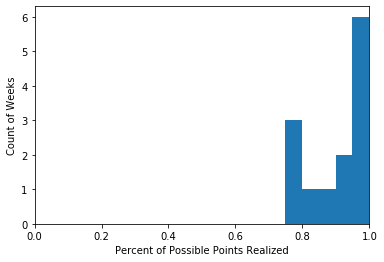

In [223]:
import matplotlib.pyplot as plt

plt.hist(weekly_points.realized_points/weekly_points.poss_points, bins='auto')  # arguments are passed to np.histogram
#plt.title("Histogram with 'auto' bins")
plt.xlim([0, 1])

plt.xlabel('Percent of Possible Points Realized')
plt.ylabel('Count of Weeks')

plt.show()





In [191]:


num_starters = 9 
num_bench = 7 

weekly = pd.DataFrame()
player = []
position = []
points = []
for i in range(num_starters):
    first_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+1)+']/td[2]/div/div/div[2]/div/div[2]/span[2]'
    second_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+1)+']/td[2]/div/div/div[2]/div/div[1]/span[1]/a'
    third_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+1)+']/td[7]/div/span'
    position.append(driver.find_element_by_xpath(first_xpath).text)
    player.append(driver.find_element_by_xpath(second_xpath).text)
    points.append(driver.find_element_by_xpath(third_xpath).text)


for i in range(num_bench):
    first_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+2+num_starters)+']/td[2]/div/div/div[2]/div/div[2]/span[2]'
    second_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+2+num_starters)+']/td[2]/div/div/div[2]/div/div[1]/span[1]/a'
    third_xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr['+str(i+2+num_starters)+']/td[7]/div/span'
    position.append(driver.find_element_by_xpath(first_xpath).text)
    player.append(driver.find_element_by_xpath(second_xpath).text)
    points.append(driver.find_element_by_xpath(third_xpath).text)

weekly = pd.DataFrame(np.transpose(np.array([position, player, points])), columns=['position', 'player', 'points'])
    
weekly
weekly['points'] = pd.to_numeric(weekly.iloc[:,2])

#find weekly highest possible points
total_score = 0
total_score = total_score + max(weekly[weekly['position'] == 'QB'].iloc[:,2])
total_score = total_score + max(weekly[weekly['position'] == 'TE'].iloc[:,2])
total_score = total_score + max(weekly[weekly['position'] == 'D/ST'].iloc[:,2])
total_score = total_score + weekly[weekly['position'] == 'RB'].nlargest(2,'points').iloc[0,2]
total_score = total_score + weekly[weekly['position'] == 'RB'].nlargest(2,'points').iloc[1,2]
total_score = total_score + weekly[weekly['position'] == 'WR'].nlargest(2,'points').iloc[0,2]
total_score = total_score + weekly[weekly['position'] == 'WR'].nlargest(2,'points').iloc[1,2]

#have to work on flex now
#remove already used players otherwise useable
flexing = weekly[weekly.position != 'QB']
flexing = flexing[flexing.position != 'D/ST']

temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'WR'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
flexing = flexing[flexing.player != temp]

temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'WR'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
flexing = flexing[flexing.player != temp]

temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'RB'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
flexing = flexing[flexing.player != temp]

temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'RB'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
flexing = flexing[flexing.player != temp]

temp = flexing.loc[flexing['player'] == flexing[flexing['position'] == 'TE'].nlargest(1,'points').iloc[0,1],:].iloc[0,1]
flexing = flexing[flexing.player != temp]

total_score = total_score + flexing.nlargest(2,'points').iloc[0,2]
total_score = total_score + flexing.nlargest(2,'points').iloc[1,2]
#have to work on flex now

total_score = round(total_score *100)
total_score = total_score/100

print(total_score)

realized_points = pd.to_numeric(driver.find_element_by_xpath('//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div/div[3]/div/div/section/table/tbody/tr/td/div/div/div[2]/table/tbody/tr/td/div/table/tbody/tr[10]/td[6]/div').text)

print(realized_points)
    

148.32
139.12


,player,position,points
0,QB,Deshaun Watson,30.72


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,position,player,points
0,QB,Deshaun Watson,30.72
1,RB,Aaron Jones,4.90
2,RB,Damien Williams,18.50
3,WR,Tyler Boyd,14.30
5,TE,George Kittle,13.40
6,RB,Ezekiel Elliott,13.30
7,WR,Donte Moncrief,3.70
8,D/ST,Ravens D/ST,14.00
9,RB,Miles Sanders,3.70
10,WR,Geronimo Allison,0.00


'John Brown'

,position,player,points
0,QB,Deshaun Watson,30.72
1,RB,Aaron Jones,4.90
2,RB,Damien Williams,18.50
3,WR,Tyler Boyd,14.30
4,WR,John Brown,26.30
5,TE,George Kittle,13.40
6,RB,Ezekiel Elliott,13.30
7,WR,Donte Moncrief,3.70
8,D/ST,Ravens D/ST,14.00
9,RB,Miles Sanders,3.70


begining of consensous rankings analysis

THIS IS WHERE THE ANALSYSIS WITH CONCENSOUS RANKINGS BEGINS









In [25]:
data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']
data.head()

len(data.player)

27

In [111]:
import pandas as pd
import numpy as np
j=0
if (j+1) < 10:
    csv_completer = '0'+str(j+1)

#get defense dataframe
data = pd.read_csv("FantasyPros-W"+csv_completer+"-D.csv")
data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']

tempy = weekly
tempy = tempy[tempy.position == 'D/ST']
pros_points = 0
rank = 150

for team in tempy.player:
    #print(team)
    #print(tempy)
    inner_temp = tempy.iloc[0,1].split(' ')
    for i in range(len(data.player)):
        if inner_temp[0].lower() in re.sub(r'[^\w\s]','',data.iloc[i,1].lower()):
            if data.iloc[i,0] < rank:
                answer = team
print(answer)
pros_points = weekly.loc[weekly['player'] == answer].iloc[0,2]

weekly

#get QB dataframe
data = pd.read_csv("FantasyPros-W"+csv_completer+"-QB.csv")
data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']

tempy = weekly
tempy = tempy[tempy.position == 'QB']

rank = 150

for player_ in tempy.player:
    #print(team)
    #print(tempy)
    inner_temp = tempy.iloc[0,1]
    for i in range(len(data.player)):
        if inner_temp[0].lower() in re.sub(r'[^\w\s]','',data.iloc[i,1].lower()):
            re.sub(r'[^\w\s]','',s)
            if data.iloc[i,0] < rank:
                rank = data.iloc[i,0]
                answer = player_
print(answer)
pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

print('POINTS WITH DESEAN AND DEFENSE', pros_points)

#get Flex dataframe
data = pd.read_csv("FantasyPros-W"+csv_completer+"-Flex.csv")
data.columns = ['Rank', 'player', 'Team', 'Position', 'Min', 'Max', 'STDev']

weekly2 = weekly
tempy = weekly2[weekly2.position == 'RB']

rank = 200

temp_data = data.loc[data['Position'] == 'RB']

#need to start 2 rbs
for j in range(2):
    #print(tempy)
    rank = 150
    for player_ in tempy.player:
        #print(player_)
        #print(type(player_))
        #inner_temp = tempy.iloc[0,1]
        for i in range(len(temp_data.player)):
            if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):
                re.sub(r'[^\w\s]','',s)
                #print('This was true')
                #print(temp_data.iloc[i,1].lower())
                #print(player_.lower())
                
                
                if temp_data.iloc[i,0] < rank:
                    rank = temp_data.iloc[i,0]
                    #print(temp_data.iloc[i,0])
                    answer = player_
                
                    
    print(answer)               
    pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

    tempy = tempy[tempy.player != answer]

    weekly2 = weekly2[weekly2.player != answer]
    
    
#work on WRs
tempy = weekly2[weekly2.position == 'WR']

rank = 150

temp_data = data.loc[data['Position'] == 'WR']

#need to start 2 rbs
for j in range(2):
    #print(tempy)
    rank = 200
    for player_ in tempy.player:
        #print(player_)
        #print(type(player_))
        #inner_temp = tempy.iloc[0,1]
        for i in range(len(temp_data.player)):
            if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):
                re.sub(r'[^\w\s]','',s)
                #print('This was tr
                if temp_data.iloc[i,0] < rank:
                    rank = temp_data.iloc[i,0]
                    #print(temp_data.iloc[i,0])
                    answer = player_
                
                    
    print(answer)             
    pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

    tempy = tempy[tempy.player != answer]

    weekly2 = weekly2[weekly2.player != answer]


    
#get the TE
tempy = weekly2[weekly2.position == 'TE']
rank = 150
temp_data = data.loc[data['Position'] == 'TE']

#need to start 2 rbs
rank = 200
for player_ in tempy.player:
    #print(player_)
    #print(type(player_))
    #inner_temp = tempy.iloc[0,1]
    for i in range(len(temp_data.player)):
        if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):
            re.sub(r'[^\w\s]','',s)
            #print('This was true')
            #print(temp_data.iloc[i,1].lower())
            #print(player_.lower())


            if temp_data.iloc[i,0] < rank:
                rank = temp_data.iloc[i,0]
                #print(temp_data.iloc[i,0])
                answer = player_


print(answer)
pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

tempy = tempy[tempy.player != answer]

weekly2 = weekly2[weekly2.player != answer]
    
    

#get the TE

tempy = weekly2[weekly2.position != 'QB']
tempy = tempy[tempy.position != 'D/ST']
temp_data = data


print(tempy)
#need to start 2 rbs
for j in range(2):
    rank = 200
    for player_ in tempy.player:
        #inner_temp = tempy.iloc[0,1]
        for i in range(len(temp_data.player)):
            if player_.lower() in re.sub(r'[^\w\s]','',temp_data.iloc[i,1].lower()):

                if temp_data.iloc[i,0] < rank:
                    rank = temp_data.iloc[i,0]
                    #print(temp_data.iloc[i,0])
                    answer = player_

    print(answer)
    pros_points = pros_points + weekly.loc[weekly['player'] == answer].iloc[0,2]

    tempy = tempy[tempy.player != answer]

    weekly2 = weekly2[weekly2.player != answer]
    
    
    
    


Ravens D/ST
Deshaun Watson
POINTS WITH DESEAN AND DEFENSE 44.72
Ezekiel Elliott
Damien Williams
Tyler Boyd
Donte Moncrief
George Kittle
   position            player  points
1        RB       Aaron Jones     4.9
4        WR        John Brown    26.3
9        RB     Miles Sanders     3.7
10       WR  Geronimo Allison     0.0
11       WR        DK Metcalf    12.9
12       WR     Albert Wilson     3.4
13       RB   Darwin Thompson     1.3
14       RB     Chase Edmonds     0.5
15       WR    Hunter Renfrow     3.3
Aaron Jones
Miles Sanders


In [119]:
weekly_points

,realized_points,poss_points,pro_points
0,139.12,148.32,116.52
1,133.36,135.26,133.36
2,121.34,144.44,121.34
3,65.10,81.70,68.40
4,190.24,201.44,195.84
5,133.50,136.50,120.40
6,130.32,135.02,127.62
7,169.56,171.26,171.26
8,130.64,149.24,149.14
9,124.68,124.68,124.68


In [134]:
import plotly.graph_objects as go
weeks = []
for i in range(1,14):
    weeks.append(i)


fig = go.Figure()
fig.add_trace(go.Bar(
    x=weeks,
    y=weekly_points.realized_points,
    name='Player Chosen Lineup',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=weeks,
    y=weekly_points.pro_points,
    name='Pro Consensus Recommended Lineup',
    marker_color='lightsalmon'
))

fig.update_layout(
    title="Possible Points Each Week vs Pro Consensus Recommended Lineup",
    xaxis_title="Week",
    yaxis_title="Points",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)

print("Weeks pro recommended line-up outperformed player chosen lineup:", sum(weekly_points.realized_points<weekly_points.pro_points))
print("Weeks player chosen line-up outperformed pro recommended lineup:", sum(weekly_points.realized_points>weekly_points.pro_points))
print("Average amount of points pro recommended line-up on average outperformed player chosen lineup", round(sum(weekly_points.pro_points-weekly_points.realized_points)/len(weekly_points.pro_points)*100)/100)

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

fig.show()



Weeks pro recommended line-up outperformed player chosen lineup: 4
Weeks player chosen line-up outperformed pro recommended lineup: 4
Average amount of points pro recommended line-up on average outperformed player chosen lineup -1.89


In [76]:
weekly2

,position,player,points
3,WR,Tyler Boyd,14.3
4,WR,John Brown,26.3
5,TE,George Kittle,13.4
7,WR,Donte Moncrief,3.7
8,D/ST,Ravens D/ST,14.0
10,WR,Geronimo Allison,0.0
11,WR,DK Metcalf,12.9
12,WR,Albert Wilson,3.4
13,RB,Darwin Thompson,1.3
14,RB,Chase Edmonds,0.5


In [132]:

getting_corr = weekly_points.loc[:,['realized_points','pro_points']]
getting_corr.corr(method ='pearson')

,realized_points,pro_points
realized_points,1.000000,0.945685
pro_points,0.945685,1.000000


In [130]:
weekly_points

,realized_points,poss_points,pro_points
0,139.12,148.32,116.52
1,133.36,135.26,133.36
2,121.34,144.44,121.34
3,65.10,81.70,68.40
4,190.24,201.44,195.84
5,133.50,136.50,120.40
6,130.32,135.02,127.62
7,169.56,171.26,171.26
8,130.64,149.24,149.14
9,124.68,124.68,124.68
